In [558]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
from mne_nirs.visualisation import plot_glm_group_topo

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [559]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 12

# Time from trigger point being evaluated
tmin = -1
tmax = 12

# How you would like to rename the numeric triggers from Aurora
# trigger_id = None
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}

# What files would you like to ignore while looping through subjects
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
ignore = [".DS_Store", ".git", ".gitignore"]

# File path to the folder containing the BIDS data.
# root_dir = '../../LabResearch/IndependentStudy/DataAnalysis/'
root_dir = '../../FV_Prelim_Data'

# Mock data folder to test pulling meta data from folder structure.
# path = "../../LabResearch/IndependentStudy/Data/BIDS-NIRS-Tapping"
# path = "../../LabResearch/IndependentStudy/Data/FA"
path = '../../FV_Prelim_Data'

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
# columns_for_glm_contrast = ['Neutral', 'Inflam']
columns_for_glm_contrast = ['Neutral', 'Concern']

# Specifies what columns to use for group level analysis.
# columns_for_group_analysis = ['Neutral', 'Inflam']
columns_for_group_analysis = ['Neutral', 'Concern']

In [560]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [561]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [562]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)
group_data

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-08/nirs/2023-02-17_002.snirf
Reading 0 ... 9088  =      0.000 ...   893.350 secs...
Events [86  0  1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-01/nirs/2023-02-17_002.snirf
Reading 0 ... 8713  =      0.000 ...   856.488 secs...
Events [66  0  1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-06/nirs/2023-02-10_004.snirf
Reading 0 ... 9282  =      0.000 ...   912.421 secs...
Events [103   0   2]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-07/nirs/2023-02-17_001.snirf
Reading 0 ... 9460  =      0.000 ...   929.918 secs...
Events [110   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-09/nirs/2023-03-01_004.snirf
Reading 0 ... 13102  =      0.000 ...  1287.927 secs...
Events [407   0 

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:289: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:289: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)


{'all_groups': {'channels_df': variable Condition    df           mse   p_value            se         t  \
0          Concern  21.0  4.126853e-12  0.178745  6.263993e-07  1.391148   
1          Neutral  21.0  4.126853e-12  0.738956  6.273092e-07  0.337680   
2            Start  21.0  4.126853e-12  0.655185  2.149083e-06  0.453013   
3         constant  21.0  4.126853e-12  0.689450  4.733191e-07 -0.405171   
4          drift_1  21.0  4.126853e-12  0.992607  1.194597e-05 -0.009377   
...            ...   ...           ...       ...           ...       ...   
21703      drift_5  21.0  1.377884e-12  0.828446  1.010108e-05 -0.219414   
21704      drift_6  21.0  1.377884e-12  0.949157  9.977163e-06  0.064532   
21705      drift_7  21.0  1.377884e-12  0.977449  9.903960e-06 -0.028606   
21706      drift_8  21.0  1.377884e-12  0.833963  9.831958e-06  0.212244   
21707      drift_9  21.0  1.377884e-12  0.847722  9.771250e-06  0.194412   

variable         theta Source Detector Chroma  Significa

In [563]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


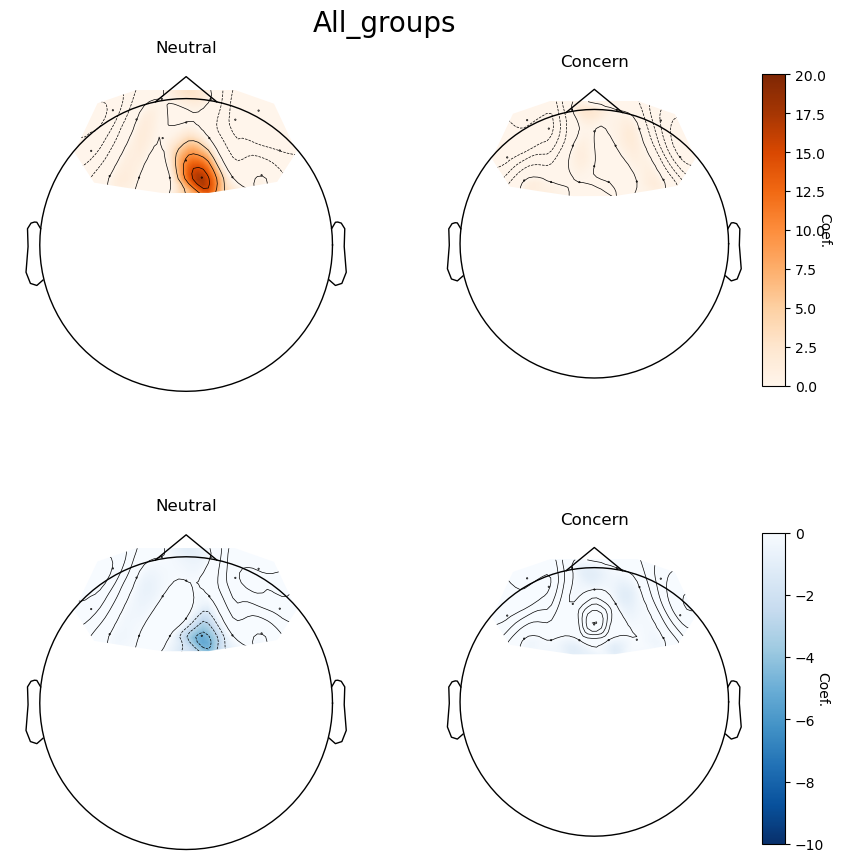

In [564]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

Concern 9
combining channels using "mean"
Neutral 9
combining channels using "mean"
Start 9
combining channels using "mean"
Concern 9
combining channels using "mean"
Neutral 9
combining channels using "mean"
Start 9
combining channels using "mean"


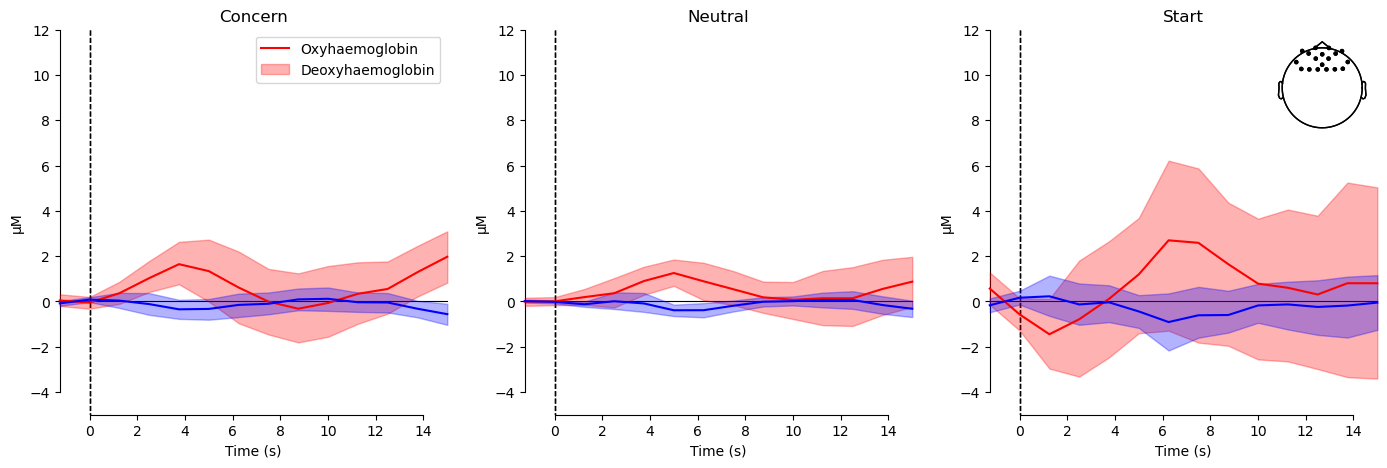

In [565]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [566]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [575]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])

complete_results.to_csv('significant_channels.csv')

                            Coef. Std.Err.         z     P>|z|    [0.025  \
ch_name   Condition                                                        
S2_D1 hbo Concern   -1.339366e-06      0.0 -2.913926  0.003569 -0.000002   
          Neutral   -1.206503e-06      0.0 -2.624869  0.008668 -0.000002   
S2_D3 hbo Concern   -1.063167e-06      0.0 -2.313028  0.020721 -0.000002   
          Neutral   -1.340118e-06      0.0 -2.915562  0.003550 -0.000002   
S3_D3 hbo Concern   -1.373147e-06      0.0 -2.987421  0.002813 -0.000002   
S4_D4 hbo Neutral    1.066321e-06      0.0  2.319890  0.020347       0.0   
S4_D5 hbo Neutral    1.735092e-06      0.0  3.774868  0.000160  0.000001   
S6_D6 hbo Neutral   -1.207099e-06      0.0 -2.626165  0.008635 -0.000002   
S8_D6 hbo Concern   -1.238249e-06      0.0 -2.693936  0.007061 -0.000002   
          Neutral   -1.400599e-06      0.0 -3.047144  0.002310 -0.000002   
S8_D7 hbo Concern   -1.623213e-06      0.0 -3.531464  0.000413 -0.000003   
          Ne